**Exploratory Data Analysis (EDA)**
---
**Go-To-Market (G2M) Case Study**
---
---

**Introduction**
---




The purpose of this notebook is to fully investigate a Market problem and analyze data in order to gain insight and propose a solution. 

**Problem description**: XYZ is a private firm in US. Due to remarkable growth in the Cab Industry in last few years and multiple key players in the market, it is planning an investment in Cab industry and as per their Go-to-Market(G2M) strategy they want to understand the market before taking final decision.

**Project target**: XYZ is interested in using resulting actionable insights to help them identify the right company to make their investment. The goal is to identify the most worth company for an investment.

---

**Data sets exploration**
---



Four distinct data sets are provided related to Cab Industry Market. There are two companies present in the data sets, the Pink Cab and the Yellow Cab. The data refer to the period betwwen 31/01/2016 and 31/12/2018 
We will now analyze each data set and their features with respect to their data types.


**1. Cab_Data.csv:** main data set with all transactions for the Pink and the Yellow Cab Companies​

*   Transaction ID: numerical discrete
*   Date of Travel: excel data format
*   Company: categorical
*   City: categorical
*   KM Travelled: numerical continuous
*   Price Charged: numerical continuous
*   Cost of Trip: numerical continuous

**2. Customer_ID.csv:** contains customer data​
*   Customer ID: numerical discrete
*   Gender: categorical
*   Age: numerical discrete
*   Income (USD/Month): numerical discrete

**3. Transaction_ID.csv:** contains transaction data​

*   Transaction ID: numerical discrete
*   Customer ID: numerical discrete
*   Payment_Mode: categorical

**4.   City.csv:** contains population data of all cities/states that transactions take place​

*   City: categorical 
*   Population: numerical discrete
*   Users: numerical discrete
---

The relationships that exist across the files are basically features that exist in both data sets. These features are:

**Transaction ID**: Cab_Data - Transaction_ID

**Customer ID**: Customer_ID - Transaction_ID

**City**: Cab_Data - City


We now demonstrate the steps needed to read and merge the data sets.

As already mentioned the Date of Travel feature was in excel format which made it impossible to derive any assumptions from it. Thus, a transformation was needed.

We firstly need to conect the drive to the colab in order to have access to the data sets. Subsequently, GitHub repository should be connected cloned to Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/
#!git clone https://github.com/lefcode/DataSets
%cd DataSets/

/content/gdrive/MyDrive
/content/gdrive/MyDrive/DataSets


Now we are set to begin. Firstly, we import all necessary libraries and create a folder to store all the resulting images the analysis will produce.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xlrd
import errno
from collections import Counter

scriptPath = os.getcwd()
IMAGESDIR = scriptPath+"/images/"
try:
    #os.makedirs(IMAGESDIR)
    !mkdir images
except FileExistsError:
    pass


mkdir: cannot create directory ‘images’: File exists


We now have create a function that reads and merges the data files. 
Additionally, as already mentioned the Date of Travel feature was in excel format which made it impossible to derive any assumptions from it. Thus, a transformation was needed to return it in yyyy-mm-dd format.

In [ ]:
cab_data_file = scriptPath+ "/Cab_Data.csv"
customer_id_file = scriptPath+"/Customer_ID.csv"
transaction_id_file = scriptPath+"/Transaction_ID.csv"
city_file = scriptPath+ "/City.csv"

def mergeDatasets(cab_data_file, customer_id_file, transaction_id_file, city_file):

    cab_data =pd.read_csv(cab_data_file)

    string_dates = list()
    # format of date from excel date to string date of format xxxx-xx-xx
    for cab in cab_data.values:
        datetime_date = xlrd.xldate_as_datetime(cab[1], 0)
        string_date = datetime_date.date().isoformat()
        string_dates.append(string_date)

    cab_data["Date of Travel"] =string_dates

    customer_id = pd.read_csv(customer_id_file)
    transaction_id = pd.read_csv(transaction_id_file)
    city = pd.read_csv(city_file)

    merged = pd.merge(cab_data, transaction_id)
    merged_dataset = pd.merge(merged, customer_id).drop_duplicates() #drop duplicates

    if merged_dataset.shape == merged_dataset.drop_duplicates().shape:
        print("No duplicates were found in dataset!")
    else:
        merged_dataset = merged_dataset.drop_duplicates()
        print(str(len(merged_dataset) - len(merged_dataset.drop_duplicates())) +" duplicates found and removed!")

    if str(merged_dataset.isnull().sum().sum())=="0":
        print("No Nan values in entire dataset!")
    else:
        print("Nan values found in the dataset. they must be handled!")

    return merged_dataset, city


merged_dataset, city = mergeDatasets(cab_data_file, customer_id_file, 
                                     transaction_id_file, city_file)

No duplicates were found in dataset!
No Nan values in entire dataset!


As shown in the previously created function the data sets that are joined are Cab_Data.csv, Customer_ID.csv and Transaction_ID.csv. 
They are merged on the already mentioned identical features.

The City.csv file is not merged with the other files because its information can be handled distinctively.

Lastly, no duplicates or NA values were found in the master data set after merging.
The total number of records of the merged data set is 359392 and the features/columns are 12.

---


**Data outliers**

While examining the data set a new insight was gained. The columns of "Price Charged" and "Cost of Trip" have many values that are outliers.

The rational hypothesis is that the charged price of a trip is higher than the cost of the trip, but this rule was intruded in some records.
For example the price charged is 370.95 while the cost of the trip is 313635.

This issue is handled with the following function which is called twice for the two columns.

In [ ]:
def outliersHandling(merged_dataset, feature):
    """ We detect and filter the outliers of Cost of Trip and Price Charged columns"""
    new_dataset = merged_dataset
    new_dataset.sort_values(feature)  # Sorting is must

    # making boolean series for the feature
    filter = new_dataset[feature] > 4

    # filtering data on basis filter
    new_dataset.where(filter, inplace=True)

    return new_dataset

new_dataset = outliersHandling(merged_dataset, "Price Charged")
new_dataset = outliersHandling(new_dataset, "Cost of Trip")

merged_dataset = new_dataset

# **Data Analysis & Hypotheses**

In this section we will be generating hypotheses and investigate through them the market of Cab Industry. Hopefully, these analysis will produce the correct results and make the decision of investing much easier and clear.

In the first step a function for creating bar plots is written, as with hindsight we realized it's reused several times in the analysis.

In [ ]:
def plotBar(labels, values1, values2, xtitle, ytitle, plot_title, plot_name, rotate="vertical"):

    fig, ax = plt.subplots(figsize=((10,8)))
    bar_width = 0.35
    X = np.arange(len(labels))
    plt.bar(X, values1, bar_width, color='pink', label='Pink Cab')

    # The bar of second plot starts where the first bar ends
    plt.bar(X + bar_width, values2, bar_width,
            color='y',
            label='Yellow Cab')
   
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(plot_title)
    plt.xticks(X + (bar_width / 2), labels, rotation=rotate)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(IMAGESDIR + plot_name +".png")

**Hypothesis 1**

The first and vital insight we would like to gain from our data is related to the overall budget and incomes of each company.

The hypothesis is the following. "Is there any relation between the total income of both cab companies in the given time period, as well as the number of rides and the average earnings from each ride and the market?"

So, a function for this purpose is created and a table of data is produced from the data for this purpose.

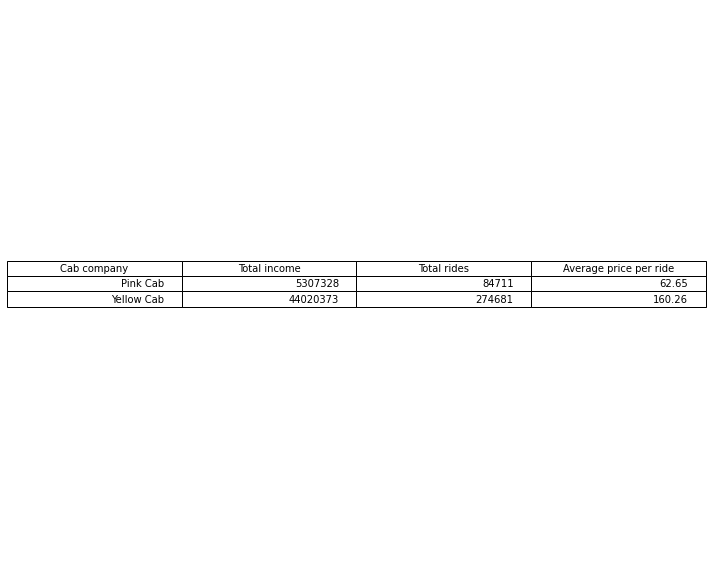

In [ ]:
def totalIncomeTable(merged_dataset):

    columns = ("Cab company","Total income","Total rides","Average price per ride")
    # total income computation
    earnings = merged_dataset.groupby(["Company"]).sum()["Price Charged"]
    expenditures = merged_dataset.groupby(["Company"]).sum()["Cost of Trip"]

    pink_cab_income = int(earnings[0] - expenditures[0])
    yellow_cab_income = int(earnings[1] - expenditures[1])

    # total rides computation
    pink_cab_rides= merged_dataset.groupby(["Company"]).count().values[0][0]
    yellow_cab_rides =  merged_dataset.groupby(["Company"]).count().values[1][0]

    # average income per ride computation
    pink_cab_average =  "%.2f" % (pink_cab_income/pink_cab_rides)
    yellow_cab_average = "%.2f" % (yellow_cab_income/yellow_cab_rides)

    pink_cab_list = ["Pink Cab", pink_cab_income, pink_cab_rides, pink_cab_average]
    yellow_cab_list = ["Yellow Cab", yellow_cab_income, yellow_cab_rides, yellow_cab_average]

    fig, ax = plt.subplots(figsize=((10,8)))
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    
    table = plt.table(cellText=[pink_cab_list,yellow_cab_list],
              colLabels=columns, loc='center')
    table.set_fontsize(24)
    fig.tight_layout()
    plt.savefig(IMAGESDIR + "totalIncomeTable.png")
    plt.show()
  
totalIncomeTable(merged_dataset)

**Hypothesis 2**

The second hypothesis is related to the cities incomes. 
The question here is "Which are the cities/states with the most customers and biggest market? Does one of the companies control these cities or the market is balanced? "

The notion is to understand which cities have more customers and income, thus they have potential for growth in the market. Generally speaking, it is better to invest in the company controlling the most cities/states instead of the opposite. Also, cities with a very small market impact should not be considered in the decision making. 

So, a function for this purpose is created and a very insightful bar chart is plotted dipicting the total income of each city.
Prominently, the Yellow Cab has the biggest percentage of the market in all cities.

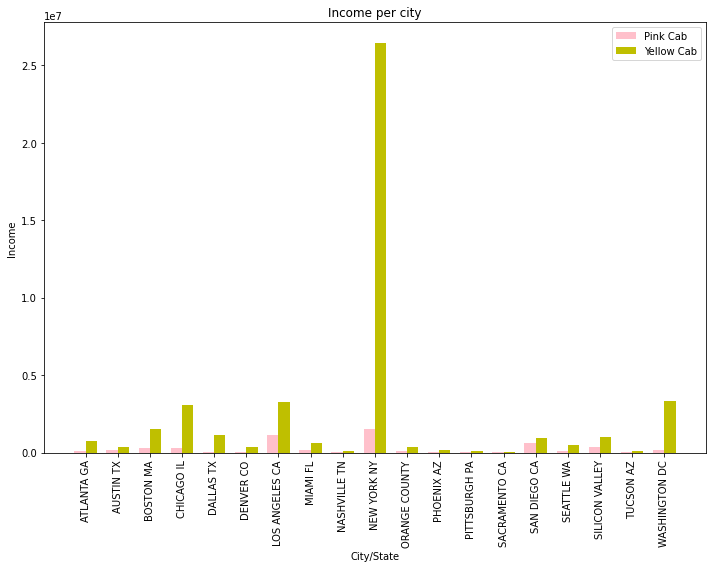

<Figure size 432x288 with 0 Axes>

In [ ]:
def cityIncomeHistogram(merged_dataset):
    city_cab = merged_dataset.groupby(["Company", "City"]).sum()["Price Charged"].index
    city_earnings = merged_dataset.groupby(["Company", "City"]).sum()["Price Charged"]
    city_expenditures = merged_dataset.groupby(["Company", "City"]).sum()["Cost of Trip"]
    cities_names = [c_cab[1] for c_cab in city_cab]
    cities=list()

    for city in cities_names:
        if city not in cities:
            cities.append(city)

    pink_cab_cities_incomes = []
    for earn, exp in zip(city_earnings["Pink Cab"], city_expenditures["Pink Cab"]):
        pink_cab_cities_incomes.append(earn-exp)

    yellow_cab_cities_incomes = []
    for earn, exp in zip(city_earnings["Yellow Cab"], city_expenditures["Yellow Cab"]):
        yellow_cab_cities_incomes.append(earn-exp)

    plotBar(cities, pink_cab_cities_incomes, yellow_cab_cities_incomes, 'City/State', 'Income', 
            'Income per city', "cityIncome")

cityIncomeHistogram(merged_dataset)

**Hypothesis 3**

The third hypothesis is related to the time period of the provided data. The hypothesis is the following: 
"Does any company have a positive income rate through the years?".

It is essential to know each company's progress throught the years.An increasing rate/ascending graph indicates the overall tention of a company to dominate the market in the future. On the contrary, a dicreasing or stable rate shows low potential for futute growth.

Two functions for this purpose are created, alogn with two graphs, to demonstate the total annual and monthly income's growth for the companies. 

The result is very insightful again as it shows that the Pink Cab doesn't have a promissing growth through the years. Admittedly, the three-year period is very small to understand the whole growth of a company.
The monthly graph gives us the insight that during the high seasons, September-December, the Yellow Cab has the control of the market and the income is higher than the Pink Cab's income.



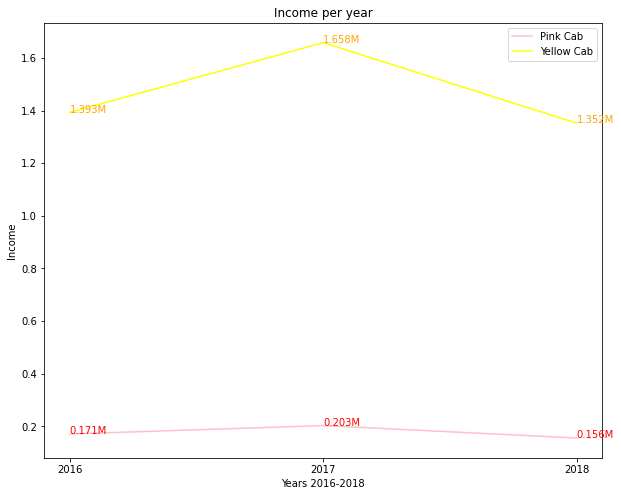

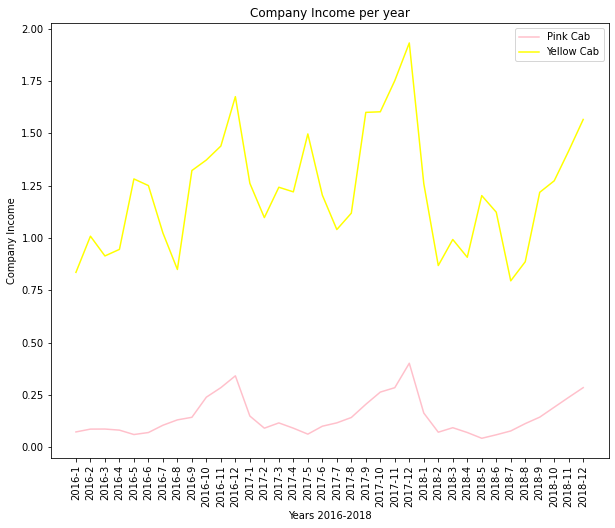

In [ ]:
def yearsIncomes(merged_dataset):
    years_earnings =merged_dataset.groupby(["Company", "Date of Travel"]).sum()["Price Charged"]
    years_expenditures = merged_dataset.groupby(["Company", "Date of Travel"]).sum()["Cost of Trip"]

    years_list = ["2016","2017","2018"]

    pink_cab_annual_income = list()
    for year in years_list:
        years_incomes = 0
        for date, earn, exp in zip(years_earnings["Pink Cab"].index ,years_earnings["Pink Cab"], years_expenditures["Pink Cab"]):
            if date.split("-")[0] == year:
                years_incomes += earn-exp

        pink_cab_annual_income.append(years_incomes/1e7) #str(years_incomes/1e7)+"M"

    yellow_cab_annual_income = list()
    for year in years_list:
        years_incomes = 0
        for date, earn, exp in zip(years_earnings["Yellow Cab"].index ,years_earnings["Yellow Cab"], years_expenditures["Yellow Cab"]):
            if date.split("-")[0] == year:
                years_incomes += earn-exp

        yellow_cab_annual_income.append(years_incomes/1e7)


    plt.figure(figsize=(10,8))
    for i in range(3):
        plt.annotate("{:.3f}M".format(pink_cab_annual_income[i]), (i,pink_cab_annual_income[i]), color="red")

    for i in range(3):
        plt.annotate("{:.3f}M".format(yellow_cab_annual_income[i]), (i,yellow_cab_annual_income[i]), color="orange")
    
    plt.plot(years_list, pink_cab_annual_income, color='pink', label="Pink Cab")
    plt.plot(years_list, yellow_cab_annual_income, color='yellow', label="Yellow Cab")
    plt.title("Income per year")
    plt.xlabel("Years 2016-2018")
    plt.ylabel("Income")
    plt.legend(loc='upper right')
    plt.savefig(IMAGESDIR + "yearsIncome.png")
    plt.show()

def monthsIncomes(merged_dataset):

    years_earnings = merged_dataset.groupby(["Company", "Date of Travel"]).sum()["Price Charged"]
    years_expenditures = merged_dataset.groupby(["Company", "Date of Travel"]).sum()["Cost of Trip"]

    years_list = ["2016","2017","2018"]
    months_list = [i for i in range(1,13)]

    labels_list = [y+"-"+str(m) for y in years_list for m in months_list]

    pink_cab_annual_monthly_income = list()
    for year in years_list:
        for month in months_list:
            month_income = 0
            for date, earn, exp in zip(years_earnings["Pink Cab"].index ,years_earnings["Pink Cab"], years_expenditures["Pink Cab"]):
                if int(date.split("-")[1]) == month and date.split("-")[0] == year:
                    month_income += (earn-exp)/1e6
            pink_cab_annual_monthly_income.append(month_income)

    yellow_cab_annual_monthly_income = list()
    for year in years_list:
        for month in months_list:
            month_income = 0
            for date, earn, exp in zip(years_earnings["Yellow Cab"].index ,years_earnings["Yellow Cab"], years_expenditures["Yellow Cab"]):
                if int(date.split("-")[1]) == month and date.split("-")[0] == year:
                    month_income += (earn-exp)/1e6
            yellow_cab_annual_monthly_income.append(month_income)

    plt.figure(figsize=(10,8))
    plt.plot(labels_list, pink_cab_annual_monthly_income, color='pink', label="Pink Cab")
    plt.plot(labels_list, yellow_cab_annual_monthly_income, color='yellow', label="Yellow Cab")
    plt.title("Company Income per year")
    plt.xlabel("Years 2016-2018")
    plt.ylabel("Company Income")
    plt.legend(loc='upper right')
    plt.xticks(rotation='vertical')
    plt.savefig(IMAGESDIR + "monthsIncome.png")
    plt.show()

yearsIncomes(merged_dataset)
monthsIncomes(merged_dataset)

**Hypothesis 4**

The fourth hypothesis is the related to the following query. "Is there any relation between a company's income and the customer's profile?". To answer that we have to analyze the data and create graphs about customer's:
1. Age: devided in 5 age classes we compute the overall company's profit from each class 
2. Income: devided in 4 monthly levels (low, middle, good, very good) we summarize the total company's income for each level.
3. Gender: Company's total income based on customer's gender.



We divide customers' ages into 5 classes: 18-23, 24-30, 31-40, 41-50, 51-65


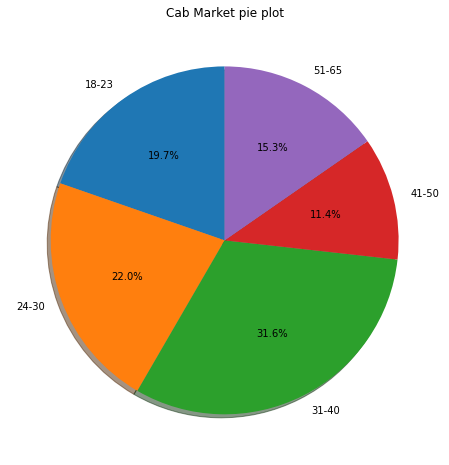

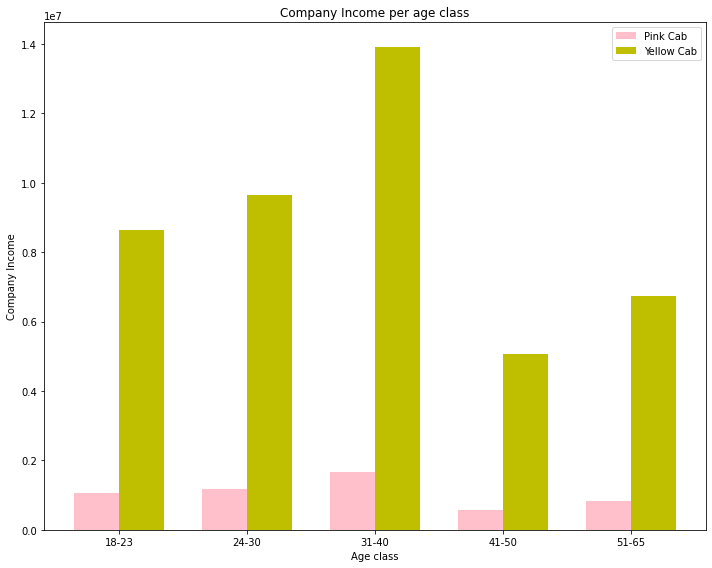

<Figure size 432x288 with 0 Axes>

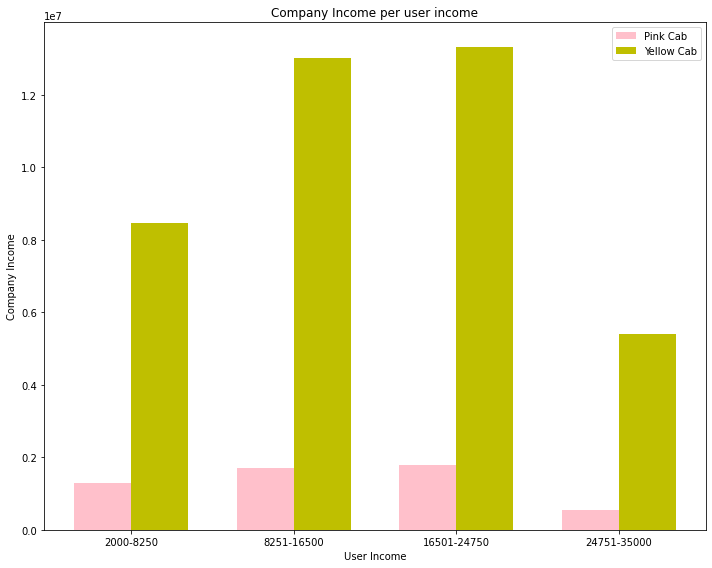

<Figure size 432x288 with 0 Axes>

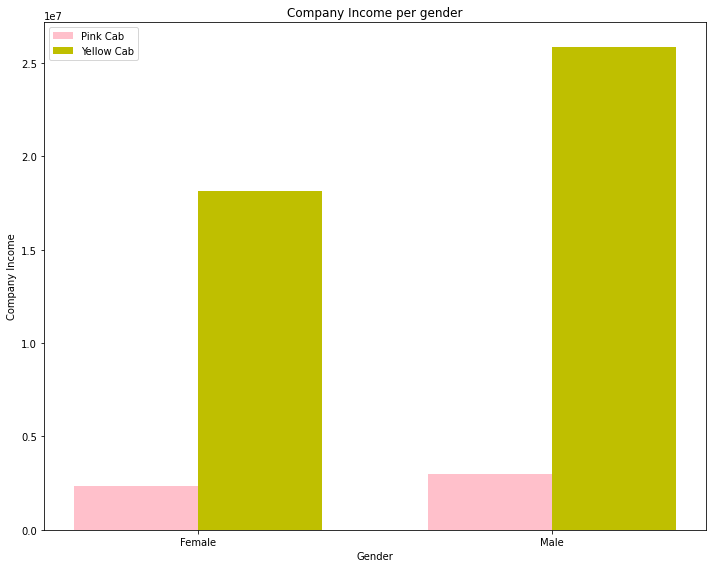

<Figure size 432x288 with 0 Axes>

In [ ]:
def ageAnalysis(merged_dataset):

    ages = merged_dataset.groupby(["Company", "Age"]).sum()["Price Charged"].index
    ages_earnings = merged_dataset.groupby(["Company", "Age"]).sum()["Price Charged"]
    ages_expenditures = merged_dataset.groupby(["Company", "Age"]).sum()["Cost of Trip"]

    pink_cab_ages_incomes = {}
    for earn, exp, age in zip(ages_earnings["Pink Cab"], ages_expenditures["Pink Cab"], ages):
        pink_cab_ages_incomes[age[1]] = earn-exp
        #pink_cab_ages_incomes.append(earn-exp)

    yellow_cab_ages_incomes = {}
    for earn, exp, age in zip(ages_earnings["Yellow Cab"], ages_expenditures["Yellow Cab"], ages):
        yellow_cab_ages_incomes[age[1]] = earn-exp
        #yellow_cab_ages_incomes.append(earn-exp)

    print("We divide customers' ages into 5 classes: 18-23, 24-30, 31-40, 41-50, 51-65")
    ages_classes = ["18-23", "24-30", "31-40", "41-50", "51-65"]

    pink_cab_ages_classes_incomes = {}
    yellow_cab_ages_classes_incomes={}

    for age_class in ages_classes:
        pink_cab_ages_classes_incomes[age_class] = 0
        yellow_cab_ages_classes_incomes[age_class] = 0

    for key, val in pink_cab_ages_incomes.items():
        if key<=23: pink_cab_ages_classes_incomes["18-23"] += val
        elif key<=30: pink_cab_ages_classes_incomes["24-30"] += val
        elif key<=40: pink_cab_ages_classes_incomes["31-40"] += val
        elif key<=50: pink_cab_ages_classes_incomes["41-50"] += val
        elif key<=65: pink_cab_ages_classes_incomes["51-65"] += val

    for key, val in yellow_cab_ages_incomes.items():
        if key <= 23: yellow_cab_ages_classes_incomes["18-23"] += val
        elif key <= 30: yellow_cab_ages_classes_incomes["24-30"] += val
        elif key <= 40: yellow_cab_ages_classes_incomes["31-40"] += val
        elif key <= 50: yellow_cab_ages_classes_incomes["41-50"] += val
        elif key <= 65: yellow_cab_ages_classes_incomes["51-65"] += val

    # add both dictionaries values
    overall_income = dict(Counter(pink_cab_ages_classes_incomes) + Counter(yellow_cab_ages_classes_incomes))
    plt.figure(figsize=(10,8))
    plt.pie(overall_income.values(), labels=ages_classes, startangle=90, shadow=True, autopct='%1.1f%%')
    plt.title('Cab Market pie plot')
    plt.savefig(IMAGESDIR + "agePiePlot.png")
    plt.show()

    plotBar(ages_classes, pink_cab_ages_classes_incomes.values(), yellow_cab_ages_classes_incomes.values(),
            "Age class", "Company Income", "Company Income per age class", "ageAnalysis", rotate = "horizontal")
    

def incomeAnalysis(merged_dataset):

    company_user_earnings_indices = merged_dataset.groupby(["Company", "Income (USD/Month)"]).sum()["Price Charged"].index
    company_user_earnings = merged_dataset.groupby(["Company", "Income (USD/Month)"]).sum()["Price Charged"]
    company_user_expenditures = merged_dataset.groupby(["Company", "Income (USD/Month)"]).sum()["Cost of Trip"]

    pink_cab_incomes = {}
    for earn, exp, c_us in zip(company_user_earnings["Pink Cab"], company_user_expenditures["Pink Cab"], company_user_earnings_indices):
        pink_cab_incomes[c_us[1]] = earn-exp

    yellow_cab_incomes = {}
    for earn, exp, c_us in zip(company_user_earnings["Yellow Cab"], company_user_expenditures["Yellow Cab"], company_user_earnings_indices):
        yellow_cab_incomes[c_us[1]] = earn-exp

    pink_cab_user_classes_incomes = {}
    yellow_cab_user_classes_incomes={}

    income_levels = ["2000-8250", "8251-16500", "16501-24750", "24751-35000"] # we divided the range of incomes to 4 levels
    for level in income_levels:
        pink_cab_user_classes_incomes[level] = 0
        yellow_cab_user_classes_incomes[level] = 0

    for key, val in pink_cab_incomes.items():
        if int(key)<=8250: pink_cab_user_classes_incomes["2000-8250"] += val
        elif int(key)<=16500: pink_cab_user_classes_incomes["8251-16500"] += val
        elif int(key)<=24750: pink_cab_user_classes_incomes["16501-24750"] += val
        elif int(key)<=35000: pink_cab_user_classes_incomes["24751-35000"] += val

    for key, val in yellow_cab_incomes.items():
        if int(key)<=8250: yellow_cab_user_classes_incomes["2000-8250"] += val
        elif int(key) <= 16500: yellow_cab_user_classes_incomes["8251-16500"] += val
        elif int(key)<=24750: yellow_cab_user_classes_incomes["16501-24750"] += val
        elif int(key) <= 35000: yellow_cab_user_classes_incomes["24751-35000"] += val

    plotBar(income_levels, pink_cab_user_classes_incomes.values(), yellow_cab_user_classes_incomes.values(),
            "User Income", "Company Income", "Company Income per user income", "incomeAnalysis", 
            rotate = "horizontal")

def genderAnalysis(merged_dataset):

    company_user_earnings_indices = merged_dataset.groupby(["Company", "Gender"]).sum()["Price Charged"].index
    company_user_earnings = merged_dataset.groupby(["Company", "Gender"]).sum()["Price Charged"]
    company_user_expenditures = merged_dataset.groupby(["Company", "Gender"]).sum()["Cost of Trip"]

    pink_cab_incomes = {}
    for earn, exp, c_us in zip(company_user_earnings["Pink Cab"], company_user_expenditures["Pink Cab"],
                               company_user_earnings_indices):
        pink_cab_incomes[c_us[1]] = earn - exp

    yellow_cab_incomes = {}
    for earn, exp, c_us in zip(company_user_earnings["Yellow Cab"], company_user_expenditures["Yellow Cab"],
                               company_user_earnings_indices):
        yellow_cab_incomes[c_us[1]] = earn - exp


    plotBar(["Female","Male"], pink_cab_incomes.values(), yellow_cab_incomes.values(),
            "Gender", "Company Income", "Company Income per gender", "genderAnalysis", rotate = "horizontal")



ageAnalysis(merged_dataset)
incomeAnalysis(merged_dataset)
genderAnalysis(merged_dataset)

The graphs indicate once more that the Yellow Cab company is dominating the market in manner of customers profiles.

The customers profiles that are profoundly more interesting are male users between 24-40 years old, with middle and/or good income level (8251-24750 in monthly bases). They are interesting for us because these type of users bring the biggest revenue to the whole Cab market, regardless the company.

In all these customers' classes the biggest percentage in the market is dominated by the Yellow Cab.


**Hypothesis 5**

The fifth and last hypothesis is the following. "Is there any connection between company's profit and ride's attributes?". Thus, we examine the two following attributes:
1. Kilometers travelled
2. Average company's income per ride

with respect to company's profits.




We divide the ΚΜ Travelled into 5 clusters


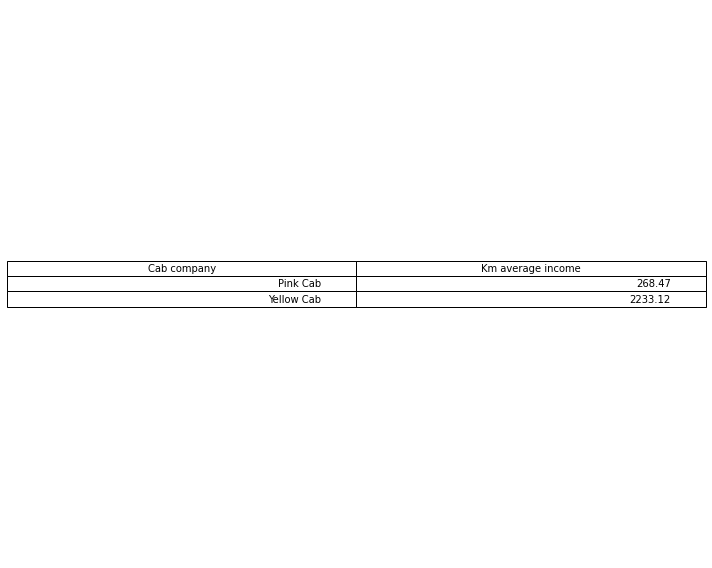

<Figure size 432x288 with 0 Axes>

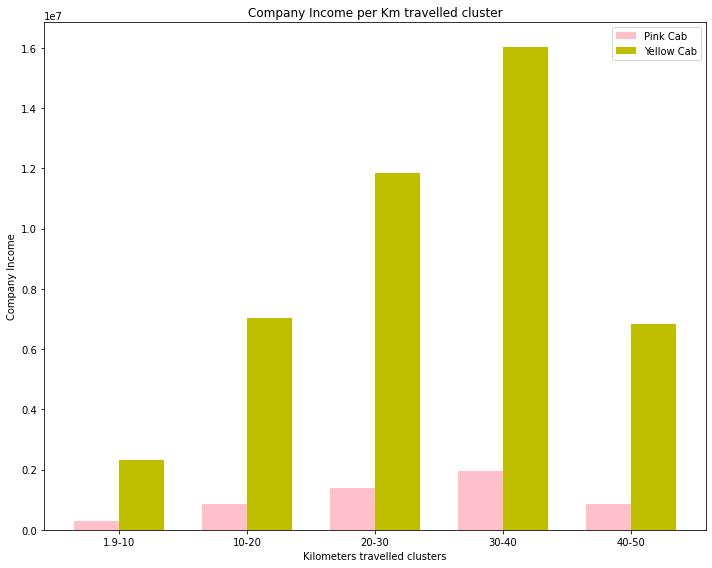

<Figure size 432x288 with 0 Axes>

In [ ]:
def kilometersIncome(merged_dataset):

    company_km_earnings_indices = merged_dataset.groupby(["Company", "KM Travelled"]).sum()["Price Charged"].index
    company_km_earnings = merged_dataset.groupby(["Company", "KM Travelled"]).sum()["Price Charged"]
    company_km_expenditures = merged_dataset.groupby(["Company", "KM Travelled"]).sum()["Cost of Trip"]

    print("We divide the ΚΜ Travelled into 5 clusters")
    km_clusters = ["1.9-10","10-20","20-30","30-40","40-50"]

    pink_cab_kms_incomes = {}
    for earn, exp, kms in zip(company_km_earnings["Pink Cab"], company_km_expenditures["Pink Cab"], company_km_earnings_indices):
        pink_cab_kms_incomes[kms[1]] = earn - exp

    yellow_cab_kms_incomes = {}
    for earn, exp, kms in zip(company_km_earnings["Yellow Cab"], company_km_expenditures["Yellow Cab"], company_km_earnings_indices):
        yellow_cab_kms_incomes[kms[1]] = earn - exp

    pink_cab_kms_clusters_incomes = {}
    yellow_cab_kms_clusters_incomes = {}

    for cluster in km_clusters:
        pink_cab_kms_clusters_incomes[cluster] = 0
        yellow_cab_kms_clusters_incomes[cluster] = 0

    pink_cab_kms_averages =list()
    for key, val in pink_cab_kms_incomes.items():
        pink_cab_kms_averages.append(val / key)
        if key <= 10:
            pink_cab_kms_clusters_incomes["1.9-10"] += val
        elif key <= 20:
            pink_cab_kms_clusters_incomes["10-20"] += val
        elif key <= 30:
            pink_cab_kms_clusters_incomes["20-30"] += val
        elif key <= 40:
            pink_cab_kms_clusters_incomes["30-40"] += val
        elif key <= 50:
            pink_cab_kms_clusters_incomes["40-50"] += val


    yellow_cab_kms_averages = list()
    for key, val in yellow_cab_kms_incomes.items():
        yellow_cab_kms_averages.append(val / key)
        if key <= 10:
            yellow_cab_kms_clusters_incomes["1.9-10"] += val
        elif key <= 20:
            yellow_cab_kms_clusters_incomes["10-20"] += val
        elif key <= 30:
            yellow_cab_kms_clusters_incomes["20-30"] += val
        elif key <= 40:
            yellow_cab_kms_clusters_incomes["30-40"] += val
        elif key <= 50:
            yellow_cab_kms_clusters_incomes["40-50"] += val

    pink_total= 0
    for p in pink_cab_kms_averages:
        pink_total+= p
    pink_average = "%.2f" % (pink_total/len(pink_cab_kms_averages))

    yellow_total= 0
    for p in yellow_cab_kms_averages:
        yellow_total+= p

    yellow_average = "%.2f" % (yellow_total/len(yellow_cab_kms_averages))

    pink_cab_list = ["Pink Cab", pink_average ]
    yellow_cab_list = ["Yellow Cab", yellow_average]
    columns = ("Cab company", "Km average income")
    fig, ax = plt.subplots(figsize=((10,8)))
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    plt.table(cellText=[pink_cab_list,yellow_cab_list],
              colLabels=columns, loc='center')

    fig.tight_layout()
    plt.show()
    plt.savefig(IMAGESDIR + "kmAverage.png")

    plotBar(km_clusters, pink_cab_kms_clusters_incomes.values(), yellow_cab_kms_clusters_incomes.values(),
            "Kilometers travelled clusters", "Company Income", "Company Income per Km travelled cluster",
            "kilometersIncome", rotate="horizontal")


kilometersIncome(merged_dataset)

# **Evaluation and conclusion**

From the 5 hypotheses that were made and the graphs produced during their implementation a conclusion can be drawn.
With full clarity we can observe the Yellow Cab company is dominating the market in terms of total income, city/state market, customer's profiles and kilometer based income.

The graphs clearly dipict an overall tendency of the Yellow Cab revenue to exceed the one of the Pink Cab company. 

This is the reason why there is no need for a model to be built with goal to predict the best investment between the two companies.

In conclusion, the XYZ company should be strongly encouraged to invest in Yellow Cab as all profits are higher. 
